In [1]:
!pip install keras

In [2]:
!pip install tensorflow

In [3]:
!pip install gensim

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

import gensim

import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [2]:
df = pd.read_csv("testntrain.csv",names=["target","ids","date","flag","user","text"])

In [3]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [4]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 349 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

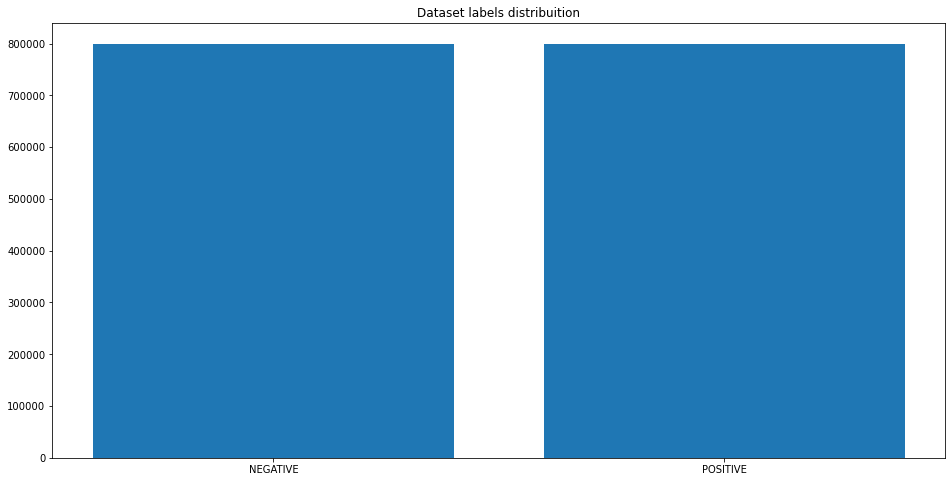

In [7]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mauru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [10]:
def create_wordcloud(text):
    words=' '.join([words for words in text])
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(words)
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [11]:
from wordcloud import WordCloud

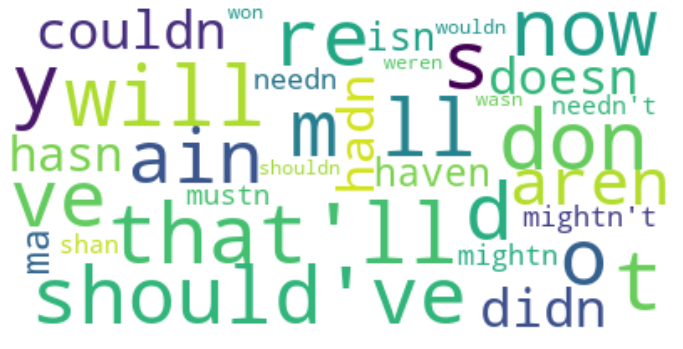

In [12]:
create_wordcloud(stop_words)

In [13]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 6
BATCH_SIZE = 100

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [14]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 35.7 s


In [16]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)

In [17]:
df_train = df_train[0:60000]
df_test = df_test[0:10000]

In [18]:
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 60000
TEST size: 10000


In [19]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 145 ms


In [20]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [21]:
w2v_model.build_vocab(documents)

In [22]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 4443


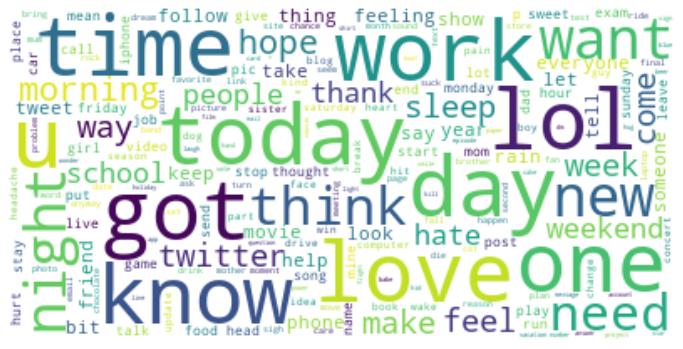

In [23]:
create_wordcloud(words)

In [24]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Wall time: 6.83 s


(10578460, 13805792)

In [25]:
w2v_model.wv.most_similar("love")

[('luv', 0.4341544508934021),
 ('loves', 0.3737696707248688),
 ('tommcfly', 0.3573945462703705),
 ('billy', 0.34827956557273865),
 ('ily', 0.3430163562297821),
 ('selena', 0.3383430242538452),
 ('mcfly', 0.32354527711868286),
 ('joe', 0.3214390277862549),
 ('mileycyrus', 0.32115620374679565),
 ('xoxo', 0.32055237889289856)]

In [26]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 42199
Wall time: 646 ms


In [27]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
print(x_train[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [28]:
print(x_train)
print("-----------------------------------------")
print(x_test)

[[    0     0     0 ...   793   113 16419]
 [    0     0     0 ...   457   349 11445]
 [    0     0     0 ...  1925     4  3869]
 ...
 [    0     0     0 ...    17     9   492]
 [    0     0     0 ...     8  1725   475]
 [    0     0     0 ...    37   122  6662]]
-----------------------------------------
[[   0    0    0 ...  703   38  108]
 [   0    0    0 ...  141 1567   27]
 [   0    0    0 ...  299  221   16]
 ...
 [   0    0    0 ...  192   29  173]
 [   0    0    0 ...  725 3642   56]
 [   0    0    0 ...  593   34  638]]


In [29]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [30]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (60000, 1)
y_test (10000, 1)


In [31]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (60000, 300)
y_train (60000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [32]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [33]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(42199, 300)


In [34]:
embedding_matrix[9]

array([ 4.79355961e-01, -2.59976685e-01, -5.50558195e-02, -5.71292222e-01,
       -1.16873765e+00, -3.83559108e-01,  5.68219543e-01, -4.19699520e-01,
       -2.02108651e-01, -1.35183439e-01, -1.82766020e-01, -1.67449728e-01,
       -9.96247008e-02,  6.72110379e-01, -5.89395821e-01, -6.30149469e-02,
        2.18484476e-01,  1.01167351e-01, -5.97655118e-01, -2.10938692e-01,
       -8.96414101e-01,  2.73243546e-01, -4.55152422e-01, -7.60866106e-01,
       -3.89635563e-01, -3.54258716e-01,  7.62520194e-01, -9.65929627e-01,
        1.34792626e-01, -2.66286314e-01,  5.71510315e-01,  5.77486813e-01,
       -1.22247823e-01,  1.10334241e+00,  2.50003695e-01, -5.10652661e-01,
        7.75962532e-01, -4.67068881e-01,  7.07221627e-01, -9.39729586e-02,
       -2.74770677e-01,  7.96913266e-01, -5.95836751e-02,  1.65679574e-01,
       -6.60501599e-01, -2.31262848e-01,  4.53700334e-01, -4.64997888e-01,
        4.05977014e-03, -5.76163173e-01,  2.76912510e-01,  1.05328763e+00,
       -4.46298309e-02,  

In [35]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35748425, -0.03806522, -0.02751208, ...,  0.09821914,
         0.29414114, -0.61697841],
       [-0.31881461,  0.09820278, -0.37134796, ...,  0.0489414 ,
        -0.45882538, -0.38045585],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [36]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [41]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          12659700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 12,820,201
Trainable params: 160,501
Non-trainable params: 12,659,700
_________________________________________________________________


In [42]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [43]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [44]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/6
100/100 [==============================] - 1678s 17s/step - loss: 0.5822 - accuracy: 0.6897 - val_loss: 0.5286 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 2/6
100/100 [==============================] - 1707s 17s/step - loss: 0.5484 - accuracy: 0.7173 - val_loss: 0.5261 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 3/6
100/100 [==============================] - 1733s 17s/step - loss: 0.5389 - accuracy: 0.7254 - val_loss: 0.5176 - val_accuracy: 0.7462 - lr: 0.0010
Epoch 4/6
100/100 [==============================] - 1764s 18s/step - loss: 0.5297 - accuracy: 0.7316 - val_loss: 0.5121 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 5/6
100/100 [==============================] - 2409s 24s/step - loss: 0.5213 - accuracy: 0.7355 - val_loss: 0.5127 - val_accuracy: 0.7572 - lr: 0.0010
Epoch 6/6
100/100 [==============================] - 2754s 28s/step - loss: 0.5164 - accuracy: 0.7401 - val_loss: 0.5131 - val_accuracy: 0.7473 - lr: 0.0010
Wall time: 3h 20min 44s


In [45]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

19/19 [==============================] - 88s 5s/step - loss: 0.5098 - accuracy: 0.7451

ACCURACY: 0.7451000213623047
LOSS: 0.5098460912704468
Wall time: 1min 27s


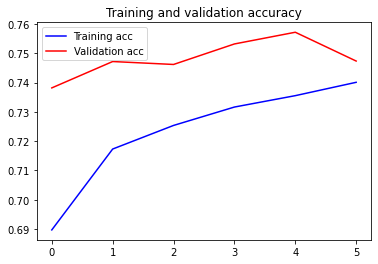

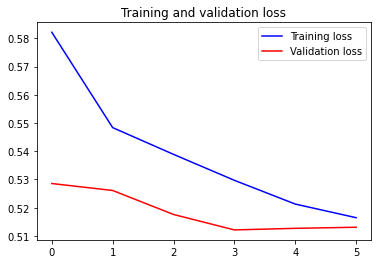

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [49]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [50]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [51]:
predict("I love the music")

1/1 [==============================] - 0s 493ms/step


{'label': 'POSITIVE',
 'score': 0.9294646382331848,
 'elapsed_time': 0.5731027126312256}

In [52]:
predict("I hate negative mindset")

1/1 [==============================] - 0s 94ms/step


{'label': 'NEGATIVE',
 'score': 0.06229744851589203,
 'elapsed_time': 0.17507243156433105}

In [53]:
predict("I have a good feeling about it")

1/1 [==============================] - 0s 103ms/step


{'label': 'NEUTRAL',
 'score': 0.4896682798862457,
 'elapsed_time': 0.18187546730041504}

In [54]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 18s 10s/step
Wall time: 18.6 s


In [55]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

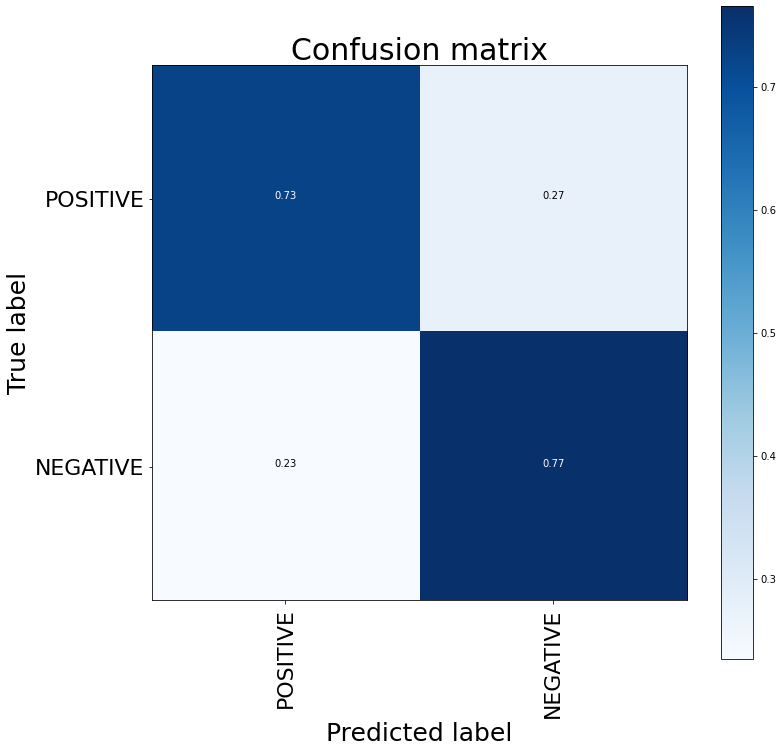

Wall time: 440 ms


In [56]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [57]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.76      0.73      0.74      5004
    POSITIVE       0.74      0.77      0.75      4996

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.74     10000



In [58]:
accuracy_score(y_test_1d, y_pred_1d)

0.7451

In [59]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)